This notebook works performs fianancial risk analysis by comparing interconnected ness of financial graphs. The adjacency matrices are loaded from an RData file.

In [1]:
import numpy as np
import pickle # save data frame (results) in a .pkl file
import pandas as pd
import os, sys
import importlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import networkx as nx
import datetime as dt
import grakel as gk
import datetime

sys.path.insert(0, 'C:/Users/User/Code/MMDGraph')
sys.path.insert(0, 'C:/Users/Users/User/Code/MMDGraph/myKernels')
import MMDforGraphs as mg
from myKernels import RandomWalk as rw
#sys.path.insert(0, 'C:/Users/Ragnar/Documents/git_code/MMDGraph'
import mgarch
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
from rpy2.robjects import pandas2ri
rpy2.robjects.numpy2ri.activate()
from mmdutils import plot_corr

Unable to determine R library path: Command '('C:\\PROGRA~1\\R\\R-41~1.3\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


In [2]:


def zero_degree(G):

    return np.any(np.array(list(dict(G.degree()).values())) == 0)


    

# Price and ESG

In [23]:
readRDS = ro.r['readRDS']
Price = readRDS('../data/FinancialGraphs/SpectralHeavy/sector_price_change.rds')
Price = dict(zip(Price.names, map(list,list(Price))))
Price['dates'] = np.array(Price['dates'])
ESG_price = readRDS('../data/FinancialGraphs/SpectralHeavy/sector_esg_price_change.rds')
ESG_price = dict(zip(ESG_price.names, map(list,list(ESG_price))))
ESG_price['dates'] = np.array(ESG_price['dates'])
#networks = dict(zip(networks.names, map(list,list(networks))))
#dates = readRDS('../data/FinancialGraphs/SpectralHeavy/Dates_by_5_per_sector.rds')
#dates = dict(zip(dates.names, map(list,list(dates))))
#dates = {sector:[dt.datetime.strptime(list(date)[0], "%Y-%m-%d").date() for date in dates[sector]] for sector in dates.keys()}


<AxesSubplot:>

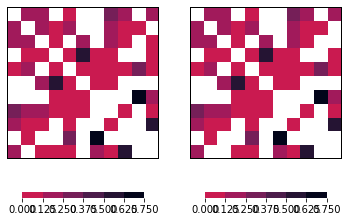

In [43]:
fig , ax= plt.subplots(1,2)
plot_corr(Price['graphs'][20], ax = ax[0])
plot_corr(ESG_price['graphs'][20], ax = ax[1])

In [29]:
G_price.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))

In [44]:
#matrix_copy = Price['graphs'][0].copy()
# matrix_copy[matrix_copy> 0] = 1
G_price = nx.from_numpy_matrix(Price['graphs'][0].copy())
G_esg = nx.from_numpy_matrix(ESG_price['graphs'][0].copy())

In [45]:
nx.set_node_attributes(G_price, {i:stock for i, stock in enumerate(Price['stock_order'])}, 'sector')
nx.set_node_attributes(G_esg, {i:stock for i, stock in enumerate(ESG_price['stock_order'])}, 'sector')

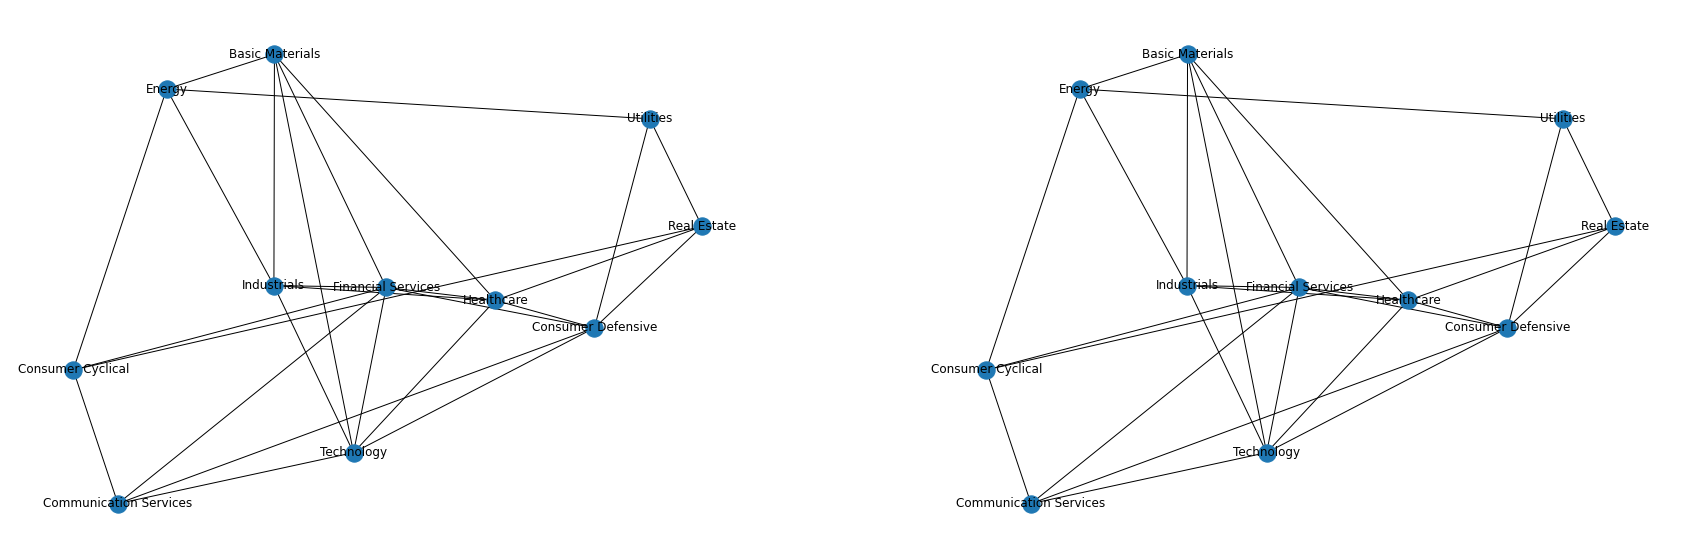

In [46]:
fig, ax = plt.subplots(1,2, figsize = (30,10))
pos = nx.spring_layout(G_price)
nx.draw(G_price, pos = pos, ax = ax[0], with_labels = True, labels =dict(G_price.nodes('sector')))
nx.draw(G_esg, pos = pos, ax = ax[1], with_labels = True, labels =dict(G_esg.nodes('sector')))

Let's create a unweighted and weighted Graphs 

In [47]:
price_unw = []
ESG_price_unw = []
price_w = []
ESG_price_w = []


for i in range(len(Price['graphs'])):
        # Price
        matrix_copy = Price['graphs'][i].copy()
        price_w.append(nx.convert.to_networkx_graph(matrix_copy))

        matrix_copy[matrix_copy> 0] = 1
        matrix_copy[matrix_copy< 0] = -1

        price_unw.append(nx.convert.to_networkx_graph(matrix_copy))
        # ESG price
        matrix_copy = ESG_price['graphs'][i].copy()
        ESG_price_w.append(nx.convert.to_networkx_graph(matrix_copy))

        matrix_copy[matrix_copy> 0] = 1
        matrix_copy[matrix_copy< 0] = -1

        ESG_price_unw.append(nx.convert.to_networkx_graph(matrix_copy))




        # # Label with degree
        # nodes_degree = dict(G_unweighted.degree())
        # labels = {key: str(value) for key, value in nodes_degree.items()}
        # nx.set_node_attributes(G_weighted, labels, 'label')
        # nx.set_node_attributes(G_unweighted, labels, 'label')

        # weighted_undirected_network_sector_list[k].append(G_weighted)
        # unweighted_undirected_network_sector_list[k].append(G_unweighted)


Let's plot some networks and perform some descriptive analysis.

In [63]:
# avg_degree_unweighted_undirected  = {i:list() for i in networks.keys()}
# avg_degree_weighted_undirected  = {i:list() for i in networks.keys()}
# density  = {i:list() for i in networks.keys()}
# avg_clustering = {i:list() for i in networks.keys()}
# density = {i:list() for i in networks.keys()}
# degree = {i:list() for i in networks.keys()}
# eigcentrality = {i:list() for i in networks.keys()}
# notfullyConnected = {i:0 for i in networks.keys()}
# zeroDegree = {i:0 for i in networks.keys()}
# nrNodes = {i:list() for i in networks.keys()}

# for k, v in networks.items():
#     for i in range(len(v)):
#         avg_degree_unweighted_undirected[k].append(avg_degree(unweighted_undirected_network_sector_list[k][i], normalize=True))
#         avg_degree_weighted_undirected[k].append(avg_degree(weighted_undirected_network_sector_list[k][i], normalize=True, weight='weight'))
#         density[k].append(nx.density(weighted_undirected_network_sector_list[k][i]))
#         avg_clustering[k].append(nx.average_clustering(weighted_undirected_network_sector_list[k][i]))
#         degree[k].append(nx.algorithms.centrality.degree_centrality(weighted_undirected_network_sector_list[k][i]))
#         eigcentrality[k].append(nx.algorithms.centrality.eigenvector_centrality(weighted_undirected_network_sector_list[k][i], max_iter=1000))
#         notfullyConnected[k] +=  int(not nx.is_connected(unweighted_undirected_network_sector_list[k][i]))
#         zeroDegree[k] += zero_degree(unweighted_undirected_network_sector_list[k][i])
#         nrNodes[k].append(unweighted_undirected_network_sector_list[k][i].number_of_nodes())


avg_degree_price = [avg_degree(price_unw[i], normalize=False) for i in range(len(price_unw))]
avg_degree_esg_price = [avg_degree(ESG_price_unw[i], normalize=False) for i in range(len(ESG_price_unw))]
avg_degree_w_price = [avg_degree(price_w[i], normalize=False, weight= 'weight') for i in range(len(price_unw))]
avg_degree_w_esg_price = [avg_degree(ESG_price_w[i], normalize=False, weight= 'weight') for i in range(len(ESG_price_unw))]



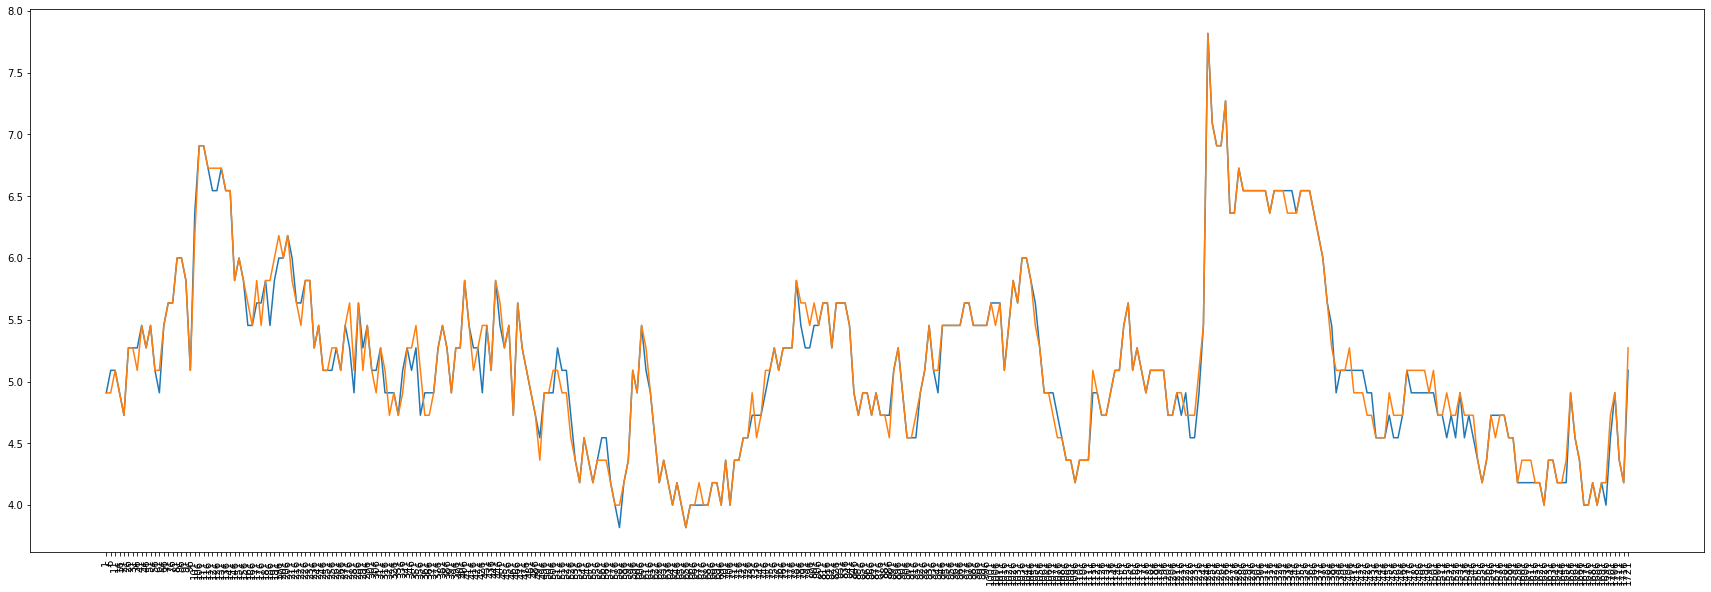

In [65]:
fig, ax = plt.subplots(1,1, figsize  = (30,10))
ax.plot(Price['dates'][:,0], avg_degree_price)
ax.plot(Price['dates'][:,0], avg_degree_esg_price)
ax.tick_params(axis='x', labelrotation=90)

# ESG Signed

In [68]:
esg_signed = pd.read_pickle('../data/ESG_Graphs/Threshold/sign.pkl')

In [69]:
esg_signed['graphs'][500].edges(data = 'sign')

EdgeDataView([(0, 1, 1.0), (0, 3, 1.0), (0, 4, 1.0), (0, 5, 1.0), (0, 6, 1.0), (0, 7, 1.0), (0, 8, 1.0), (0, 9, -1.0), (0, 10, -1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0), (1, 6, 1.0), (1, 7, 1.0), (1, 8, 1.0), (1, 9, -1.0), (1, 10, -1.0), (2, 4, 1.0), (3, 4, 1.0), (3, 5, 1.0), (3, 6, 1.0), (3, 7, 1.0), (3, 8, 1.0), (3, 9, -1.0), (3, 10, -1.0), (4, 5, 1.0), (4, 6, 1.0), (4, 7, 1.0), (4, 8, 1.0), (4, 9, -1.0), (4, 10, -1.0), (5, 6, 1.0), (5, 7, 1.0), (5, 8, 1.0), (5, 9, -1.0), (5, 10, -1.0), (6, 7, 1.0), (6, 8, 1.0), (6, 9, -1.0), (6, 10, -1.0), (7, 8, 1.0), (7, 9, -1.0), (7, 10, -1.0), (8, 9, -1.0), (8, 10, -1.0), (9, 10, 1.0)])

In [121]:
years = [2014,2015, 2016, 2017, 2018, 2019, 2020, 2021]
sample_year = {str(i):[] for i in years}

for i, date in enumerate(esg_signed['dates']):

    sample_year[str(date.year)].append(esg_signed['graphs'][i])

# for year in years:
#     sample_year[str(date.year)] = sample_year[str(date.year)]





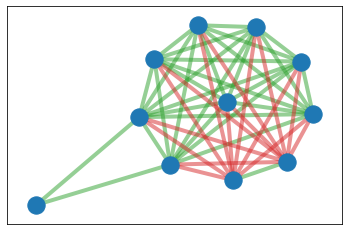

In [203]:
year = '2021'
i = 50
G = sample_year[year][i]
pos_edge = [(edge[0], edge[1]) for edge in G.edges(data = 'sign') if edge[2] == 1]
neg_edge = [(edge[0], edge[1]) for edge in G.edges(data = 'sign') if edge[2] == -1]
pos = nx.kamada_kawai_layout( G)
nx.draw_networkx_nodes(G, pos = pos)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=pos_edge,
    width=4,
    alpha=0.5,
    edge_color="tab:green",
)

nx.draw_networkx_edges(
    G,
    pos,
    edgelist=neg_edge,
    width=4,
    alpha=0.5,
    edge_color="tab:red",
)



## Hypothesis test

In [125]:
sample_year[str(years[j])]

In [180]:
sign_info_esg_sign = pd.DataFrame()
for i in range(len(years)-1):
    for j in range(1+i,len(years)):

        print([i, j])

        G1 = sample_year[str(years[i])]
        for G in G1:
            G_labels = dict(( (i, ''.join(map(str,sorted([ int(info[2]) for info in G.edges(i, data = 'sign')]))) ) for i in range(len(G))))
            nx.set_node_attributes(G, G_labels, 'label')
        G2 = sample_year[str(years[j])]
        for G in G2:
            G_labels = dict(( (i, ''.join(map(str,sorted([ int(info[2]) for info in G.edges(i, data = 'sign')]))) ) for i in range(len(G))))
            nx.set_node_attributes(G, G_labels, 'label')

        n = min(len(G1), len(G2))
        m = min(len(G1), len(G2))

        Gs = G1[:n] + G2[:n]
        graph_list = gk.graph_from_networkx(Gs, node_labels_tag='label')  # Convert to graphs to Grakel format
        kernel = [{"name": "WL-OA", "n_iter": 3}]
        init_kernel = gk.GraphKernel(kernel= kernel, normalize=0)
        K = init_kernel.fit_transform(graph_list)
        MMD_functions = [mg.MMD_b, mg.MMD_u]#, mg.MONK_EST]
        kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
        function_arguments = [dict(n = n, m = m  ), 
                                    dict(n = n, m = m )] 
                                #dict(Q = 9, y1 = Gs[:n], y2 = Gs[n:] )]


        kernel_hypothesis.Bootstrap(K, function_arguments, B = 10000)
        tmp_df_2 = pd.DataFrame(kernel_hypothesis.p_values, index = [0])
        tmp_df_2['NBB'] = None
        tmp_df_2['year1'] = str(years[i])
        tmp_df_2['year2'] = str(years[j])
        tmp_df_2['Type'] = 'Permuation'
        sign_info_esg_sign = pd.concat((sign_info_esg_sign, tmp_df_2))

        kernel_hypothesis.Bootstrap(K, function_arguments, B = 10000, method = 'NBB', boot_arg = {'l':5 ,'n':n, 'm':m})

        tmp_df_2 = pd.DataFrame(kernel_hypothesis.p_values, index = [0])
        tmp_df_2['NBB'] = 5
        tmp_df_2['year1'] = str(years[i])
        tmp_df_2['year2'] = str(years[j])
        tmp_df_2['Type'] = 'NBB'
        sign_info_esg_sign = pd.concat((sign_info_esg_sign, tmp_df_2))

        tmp_df_2 = pd.DataFrame({'MMD_b':mg.WildBootstrap(K, 5, n, m, 3000)[0], 'MMD_u':mg.WildBootstrap(K, 1, n, m, 10000)[0]}, index = [0])
        tmp_df_2['NBB'] = None
        tmp_df_2['year1'] = str(years[i])
        tmp_df_2['year2'] = str(years[j])
        tmp_df_2['Type'] = 'Wild'
        sign_info_esg_sign = pd.concat((sign_info_esg_sign, tmp_df_2))

    


[0, 1]
[0, 2]
[0, 3]
[0, 4]
[0, 5]
[0, 6]
[0, 7]
[1, 2]
[1, 3]
[1, 4]
[1, 5]
[1, 6]
[1, 7]
[2, 3]
[2, 4]
[2, 5]
[2, 6]
[2, 7]
[3, 4]
[3, 5]
[3, 6]
[3, 7]
[4, 5]
[4, 6]
[4, 7]
[5, 6]
[5, 7]
[6, 7]


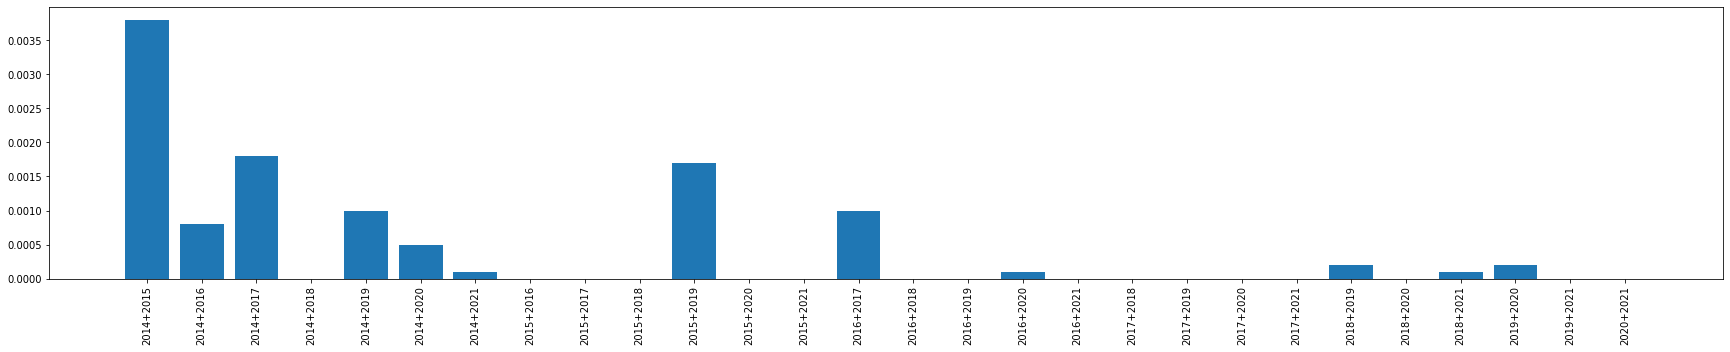

In [213]:
sign_info_esg_sign['id'] = sign_info_esg_sign['year1'] + "+" + sign_info_esg_sign['year2']
fig, ax = plt.subplots(1,1, figsize = (30, 5))

ax.bar(sign_info_esg_sign['id'].loc[sign_info_esg_sign['Type'] == 'Wild'], sign_info_esg_sign['MMD_u'].loc[sign_info_esg_sign['Type'] == 'Wild'])
ax.tick_params(axis='x', labelrotation= 90)

# ESG degree

In [ ]:
esg_signed = pd.read_pickle('../data/ESG_Graphs/Threshold/sign.pkl')
years = [2014,2015, 2016, 2017, 2018, 2019, 2020, 2021]
sample_year = {str(i):[] for i in years}

for i, date in enumerate(esg_signed['dates']):

    sample_year[str(date.year)].append(esg_signed['graphs'][i])

Text(0, 0.5, 'Average Degree')

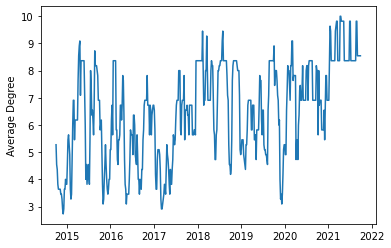

In [222]:
avg_degree_esg = [avg_degree(esg_signed['graphs'][i], normalize=False) for i in range(len(esg_signed['graphs']))]
plt.plot(esg_signed['dates'], avg_degree_esg)
plt.ylabel( "Average Degree")

In [181]:
sign_info = pd.DataFrame()
for i in range(len(years)-1):
    for j in range(1+i,len(years)):

        print([i, j])

        G1 = sample_year[str(years[i])]
        for G in G1:
            G_labels = dict(( (i, ''.join(map(str,sorted([ int(info[2]) for info in G.edges(i, data = 'sign')]))) ) for i in range(len(G))))
            nx.set_node_attributes(G, G_labels, 'label')
        G2 = sample_year[str(years[j])]
        for G in G2:
            G_labels = dict(( (i, ''.join(map(str,sorted([ int(info[2]) for info in G.edges(i, data = 'sign')]))) ) for i in range(len(G))))
            nx.set_node_attributes(G, G_labels, 'label')

        n = min(len(G1), len(G2))
        m = min(len(G1), len(G2))

        Gs = G1[:n] + G2[:n]

        rw_kernel = rw.RandomWalk(Gs, normalize= 0, c = 0.001)
        K = rw_kernel.fit_ARKU_plus(r = 10)


        MMD_functions = [mg.MMD_b, mg.MMD_u]#, mg.MONK_EST]
        kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
        function_arguments = [dict(n = n, m = m  ), 
                                    dict(n = n, m = m )] 
                                #dict(Q = 9, y1 = Gs[:n], y2 = Gs[n:] )]


        kernel_hypothesis.Bootstrap(K, function_arguments, B = 3000)
        tmp_df_2 = pd.DataFrame(kernel_hypothesis.p_values, index = [0])
        tmp_df_2['NBB'] = None
        tmp_df_2['year1'] = str(years[i])
        tmp_df_2['year2'] = str(years[i])
        tmp_df_2['Type'] = 'Permuation'
        sign_info = pd.concat((sign_info, tmp_df_2))

        kernel_hypothesis.Bootstrap(K, function_arguments, B = 10000, method = 'NBB', boot_arg = {'l':5 ,'n':n, 'm':m})

        tmp_df_2 = pd.DataFrame(kernel_hypothesis.p_values, index = [0])
        tmp_df_2['NBB'] = 5
        tmp_df_2['year1'] = str(years[i])
        tmp_df_2['year2'] = str(years[j])
        tmp_df_2['Type'] = 'NBB'
        sign_info = pd.concat((sign_info, tmp_df_2))

        tmp_df_2 = pd.DataFrame({'MMD_b':mg.WildBootstrap(K, 5, n, m, 3000)[0], 'MMD_u':mg.WildBootstrap(K, 1, n, m, 10000)[0]}, index = [0])
        tmp_df_2['NBB'] = None
        tmp_df_2['year1'] = str(years[i])
        tmp_df_2['year2'] = str(years[j])
        tmp_df_2['Type'] = 'Wild'
        sign_info = pd.concat((sign_info, tmp_df_2))

    


[0, 1]


  0%|          | 0/741.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 741/741.0 [00:07<00:00, 97.13it/s] 


[0, 2]


  0%|          | 0/741.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 741/741.0 [00:07<00:00, 93.47it/s] 


[0, 3]


  0%|          | 0/741.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 741/741.0 [00:08<00:00, 90.17it/s] 


[0, 4]


  0%|          | 0/741.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 741/741.0 [00:07<00:00, 102.18it/s]


[0, 5]


  0%|          | 0/741.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 741/741.0 [00:07<00:00, 95.88it/s] 


[0, 6]


  0%|          | 0/741.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 741/741.0 [00:07<00:00, 100.40it/s]


[0, 7]


  0%|          | 0/741.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 741/741.0 [00:07<00:00, 105.83it/s]


[1, 2]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [01:47<00:00, 99.89it/s] 


[1, 3]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [01:39<00:00, 107.76it/s]


[1, 4]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [01:38<00:00, 109.48it/s]


[1, 5]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [01:43<00:00, 103.23it/s]


[1, 6]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [00:53<00:00, 202.43it/s]


[1, 7]


  0%|          | 0/6105.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 6105/6105.0 [00:08<00:00, 744.00it/s]


[2, 3]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [00:20<00:00, 515.74it/s]


[2, 4]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [00:17<00:00, 609.38it/s]


[2, 5]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [00:13<00:00, 813.05it/s]


[2, 6]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [00:14<00:00, 739.49it/s]


[2, 7]


  0%|          | 0/6105.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 6105/6105.0 [00:08<00:00, 690.89it/s]


[3, 4]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [00:19<00:00, 557.85it/s]


[3, 5]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [00:14<00:00, 765.13it/s]


[3, 6]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [00:21<00:00, 510.38it/s]


[3, 7]


  0%|          | 0/6105.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 6105/6105.0 [00:10<00:00, 607.84it/s]


[4, 5]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [00:21<00:00, 509.71it/s]


[4, 6]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [00:17<00:00, 625.69it/s]


[4, 7]


  0%|          | 0/6105.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 6105/6105.0 [00:08<00:00, 693.82it/s]


[5, 6]


  0%|          | 0/10731.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 10731/10731.0 [00:16<00:00, 659.69it/s]


[5, 7]


  0%|          | 0/6105.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 6105/6105.0 [00:09<00:00, 628.31it/s]


[6, 7]


  0%|          | 0/6105.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:903: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
100%|██████████| 6105/6105.0 [00:11<00:00, 518.55it/s]


In [214]:
sign_info

,MMD_b,MMD_u,NBB,year1,year2,Type
0,0.0000,0.0000,None,2014,2014,Permuation
0,0.0531,0.0531,5,2014,2015,NBB
0,0.0000,0.0000,None,2014,2015,Wild
0,0.0000,0.0000,None,2014,2014,Permuation
0,0.0183,0.0142,5,2014,2016,NBB
...,...,...,...,...,...,...
0,0.0000,0.0000,5,2019,2021,NBB
0,0.0000,0.0000,None,2019,2021,Wild
0,0.0000,0.0000,None,2020,2020,Permuation
0,0.0001,0.0001,5,2020,2021,NBB


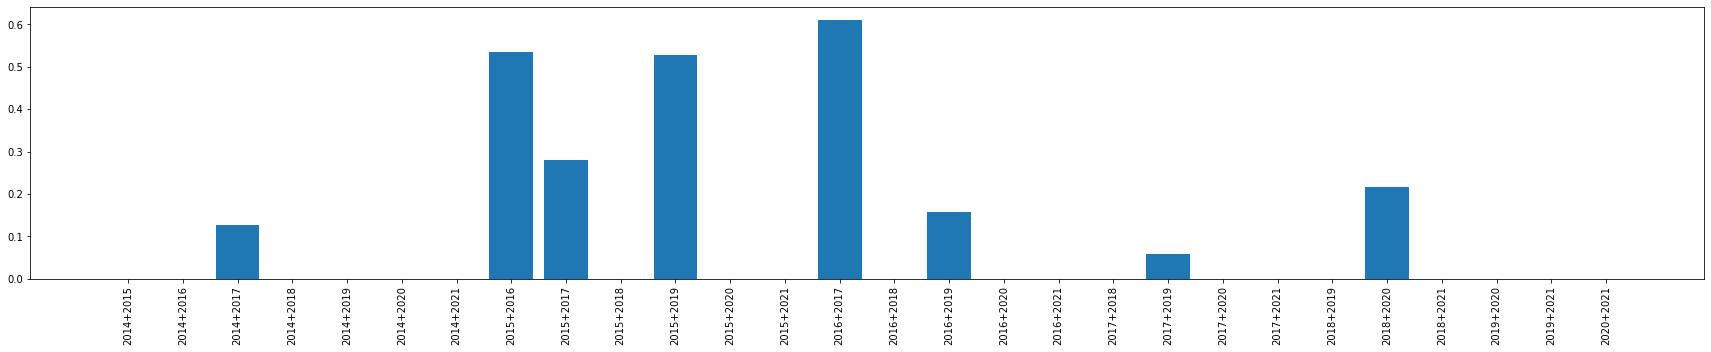

In [216]:
sign_info['id'] = sign_info['year1'] + "+" + sign_info['year2']
fig, ax = plt.subplots(1,1, figsize = (30, 5))

ax.bar(sign_info['id'].loc[sign_info['Type'] == 'Wild'], sign_info['MMD_u'].loc[sign_info['Type'] == 'Wild'])
ax.tick_params(axis='x', labelrotation= 90)

# Price Only

In [12]:
notfullyConnected

{'Basic Materials': 0,
 'Communication Services': 1,
 'Consumer Cyclical': 0,
 'Consumer Defensive': 0,
 'Energy': 0,
 'Financial Services': 0,
 'Healthcare': 0,
 'Industrials': 0,
 'Real Estate': 0,
 'Technology': 0,
 'Utilities': 0}

In [13]:
zeroDegree

{'Basic Materials': 0,
 'Communication Services': 0,
 'Consumer Cyclical': 0,
 'Consumer Defensive': 0,
 'Energy': 0,
 'Financial Services': 0,
 'Healthcare': 0,
 'Industrials': 0,
 'Real Estate': 0,
 'Technology': 0,
 'Utilities': 0}

In [25]:
# Code to plot

def plot_graph_stat(stat_dict, x = None, heat = False, figsize = (20, 20)):
    """
    stat_dict - dictionary where the keys are sector and the values are list with a graph statistic ordered in time
    x is values for x axis
    
    """

    from matplotlib.colors import ListedColormap
    from matplotlib import cm
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", 
    "493548",]
    cmap = sns.color_palette("viridis", as_cmap=True)

    
    fig, ax = plt.subplots(4, 3, figsize = figsize)

    if x is None:
        x = range(len(stat_dict[list(stat_dict.keys())[0]]))

    i = 0
    j = 0
    for k, v in stat_dict.items():
        idx = i % 4
        jdx = j % 3

        data_to_plot = pd.DataFrame(v, index = x)
        p = data_to_plot.shape[1]

    

        # ugly loop because I cant figure out a better way for colors

        if heat:
            sns.heatmap(data_to_plot, ax = ax[idx,jdx])
        else:

            if p == 1:
                colors = ['#1d3557']
            else:
                sort_index = np.argsort(data_to_plot.iloc[0,:])
                data_to_plot = data_to_plot.iloc[:, sort_index]
                colors = cmap(np.linspace(0,1,p))
            for index in range(p):
                ax[idx,jdx].plot(data_to_plot.iloc[:,index], color = colors[index])
                ax[idx,jdx].axvline(datetime.date(2020, 3, 12))


        ax[idx,jdx].set_title(k)
        ax[idx,jdx].tick_params(axis='x', rotation=90)

        i +=1
        j +=1

    fig.subplots_adjust(hspace=.5)


Numbe of nodes

In [15]:
{k:nrNodes[k][0] for k in networks.keys()}.keys()

dict_keys(['Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities'])

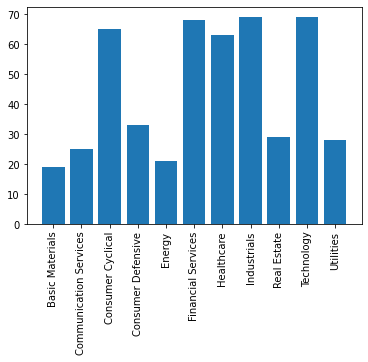

In [16]:

o = plt.bar({k:nrNodes[k][0] for k in networks.keys()}.keys(), {k:nrNodes[k][0] for k in networks.keys()}.values())
o = plt.xticks(rotation = 90)

# Plot

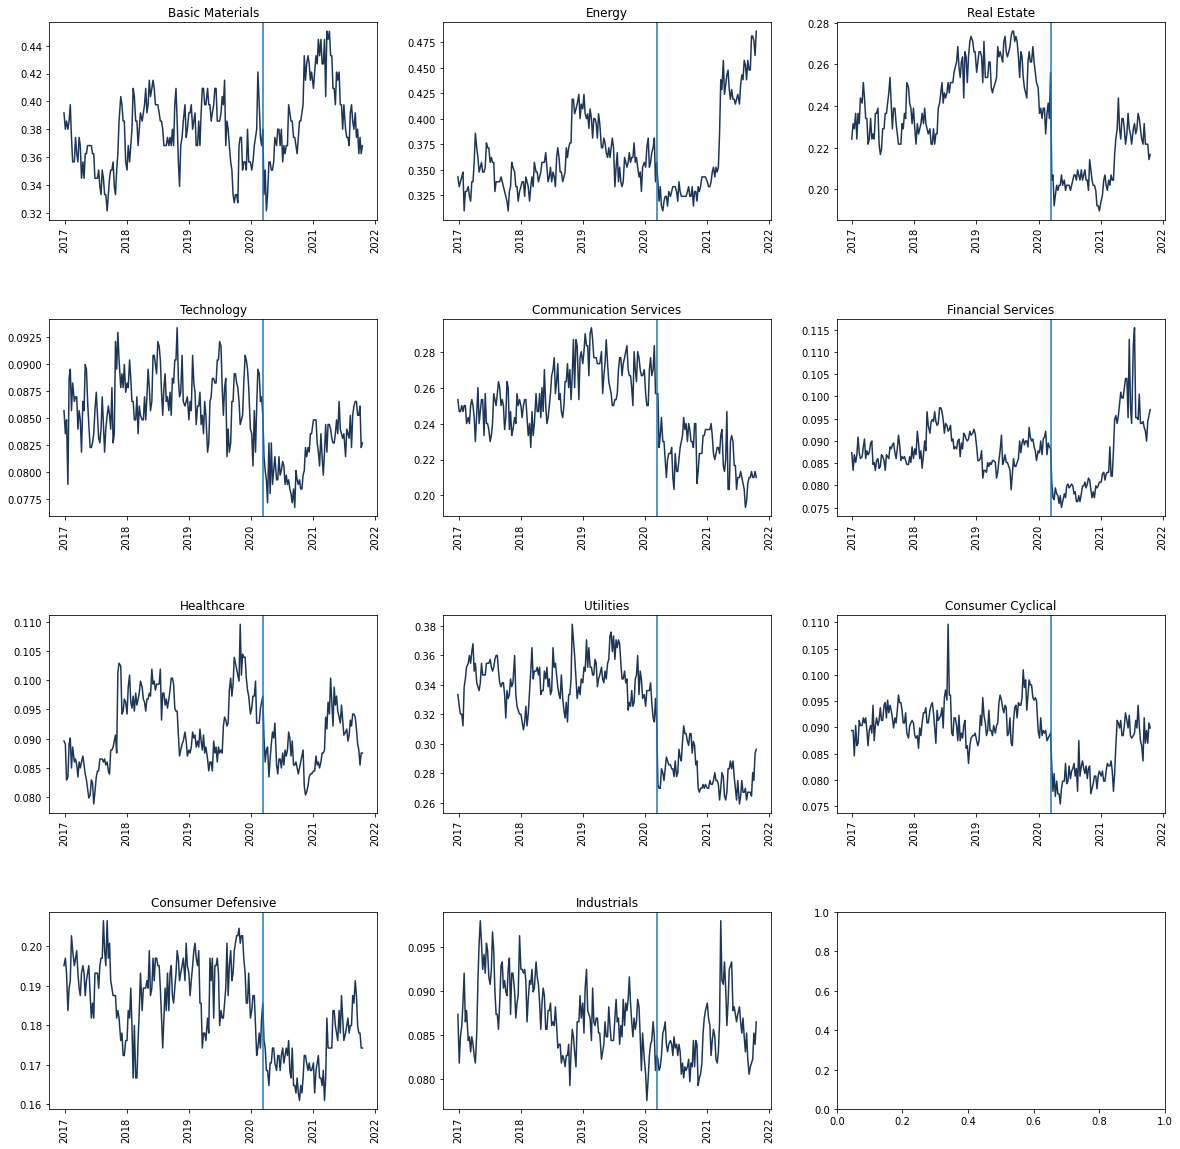

In [59]:
plot_graph_stat(avg_degree_unweighted_undirected, x = dates['Technology'])

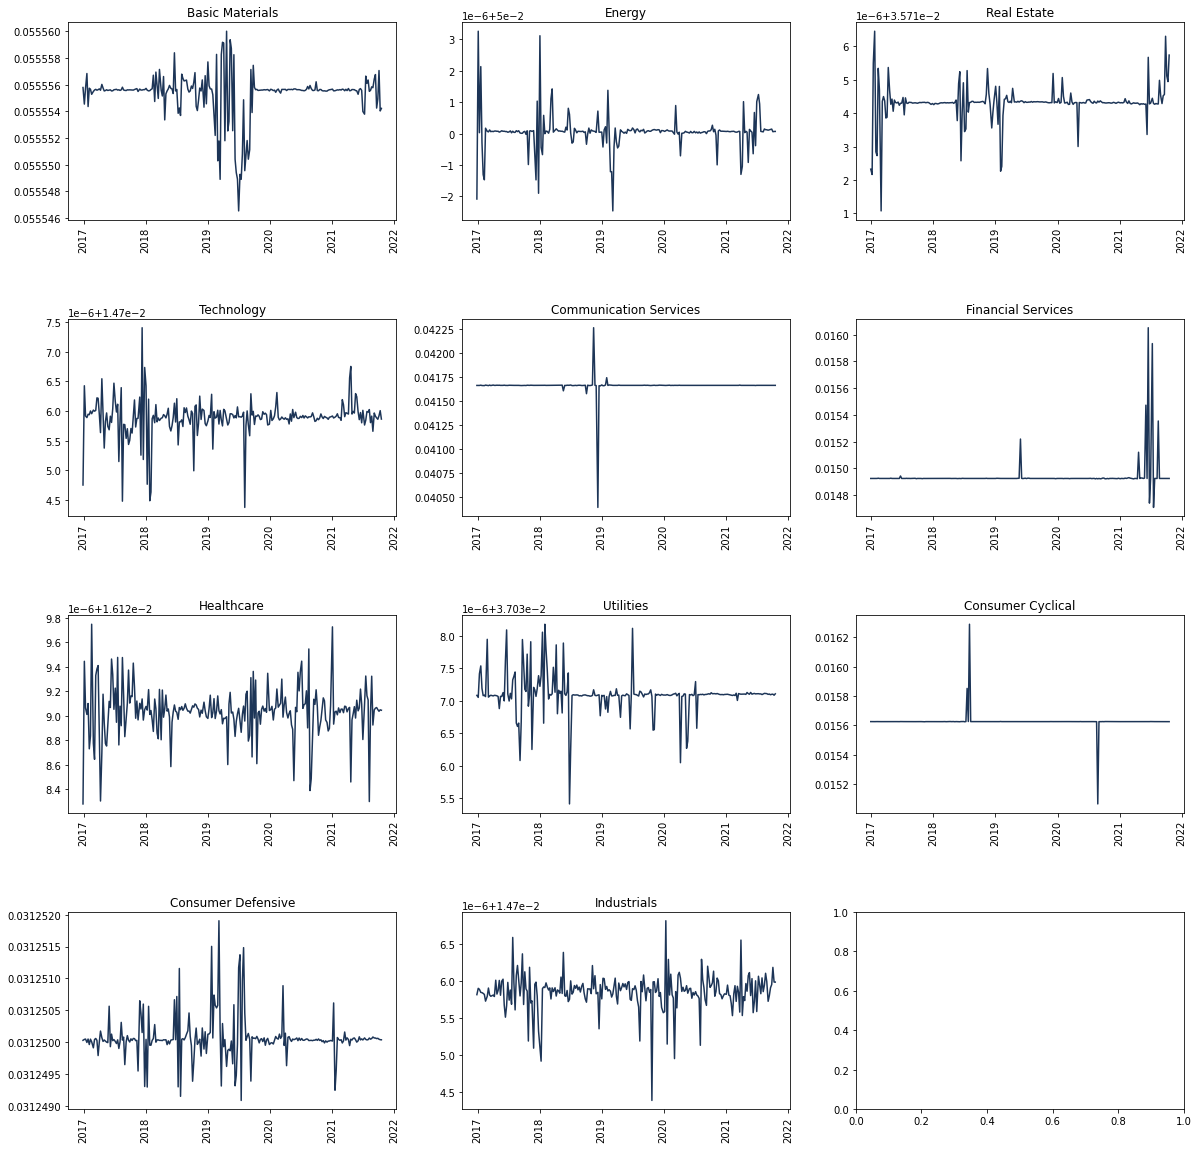

In [59]:
plot_graph_stat(avg_degree_weighted_undirected, x = dates['Technology'])

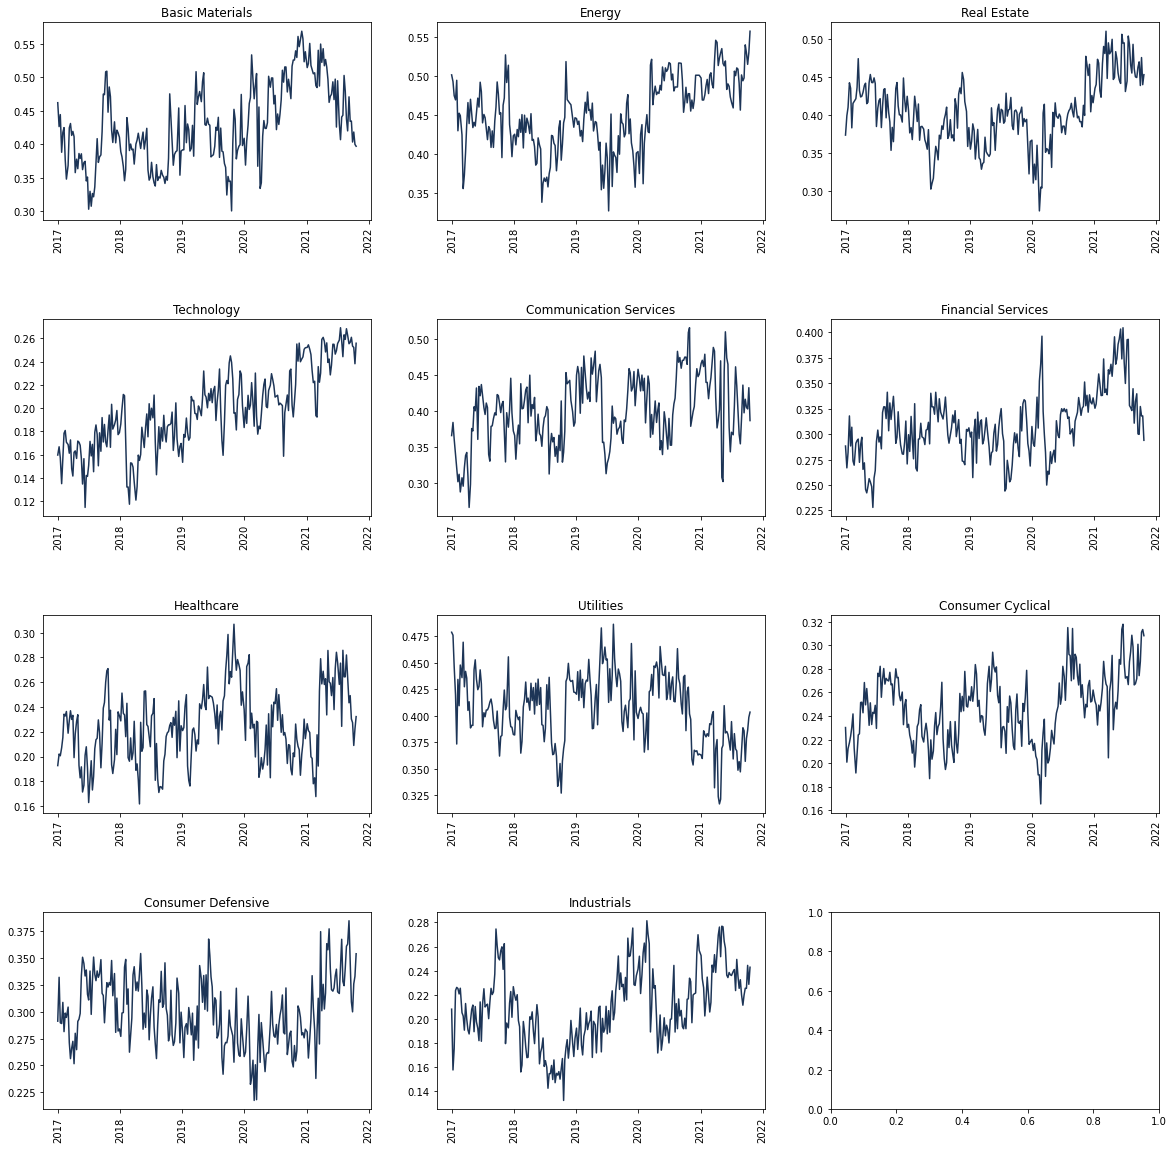

In [72]:
plot_graph_stat(avg_clustering, x = dates['Technology'])

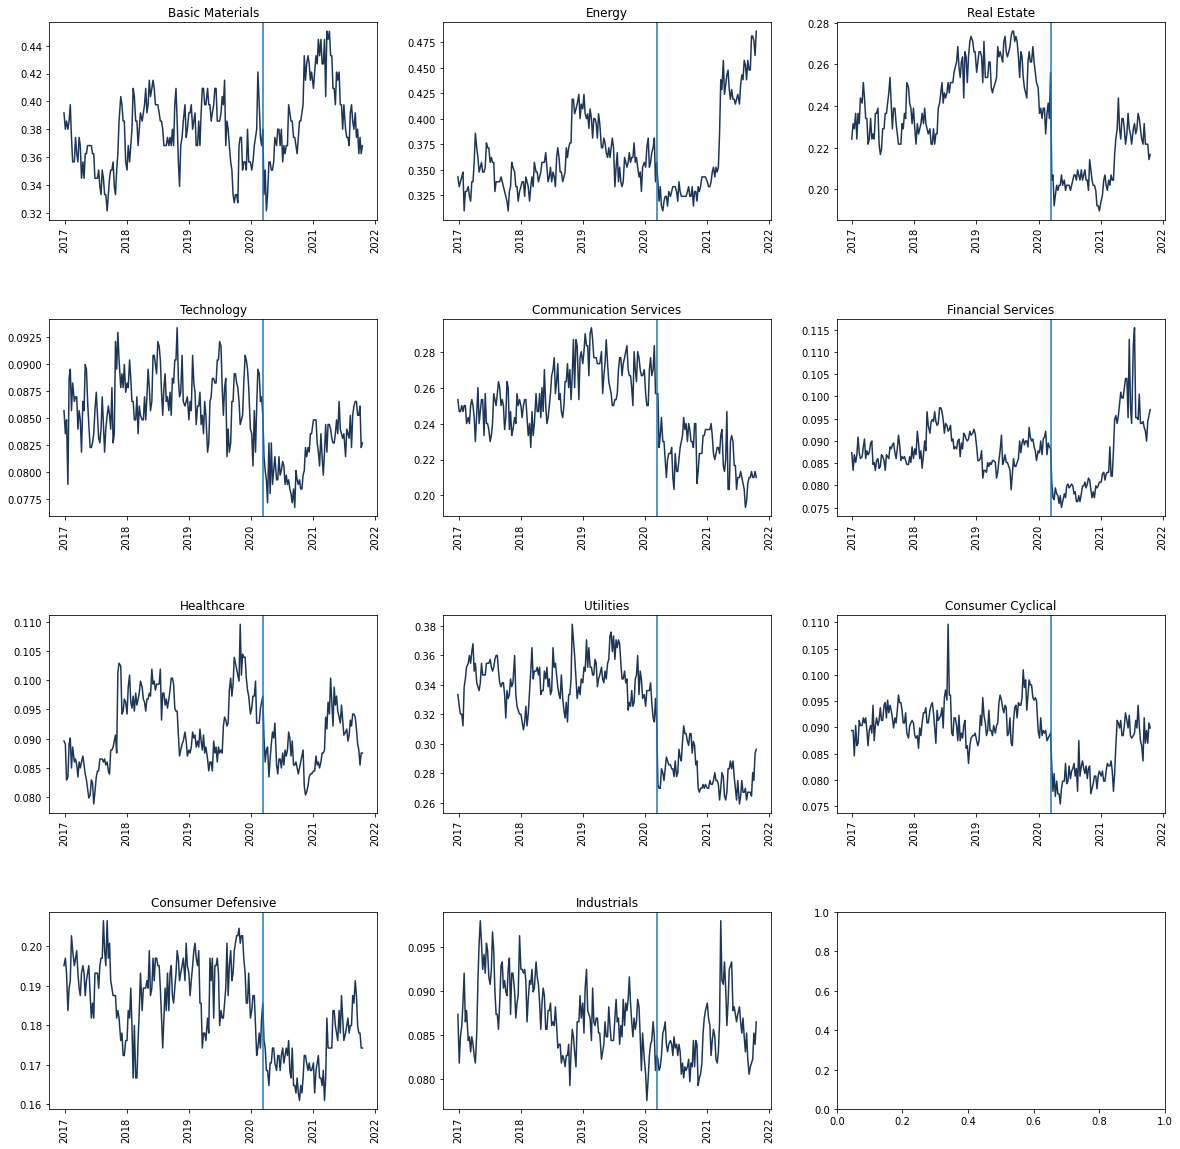

In [60]:
plot_graph_stat(density, x = dates['Technology'])

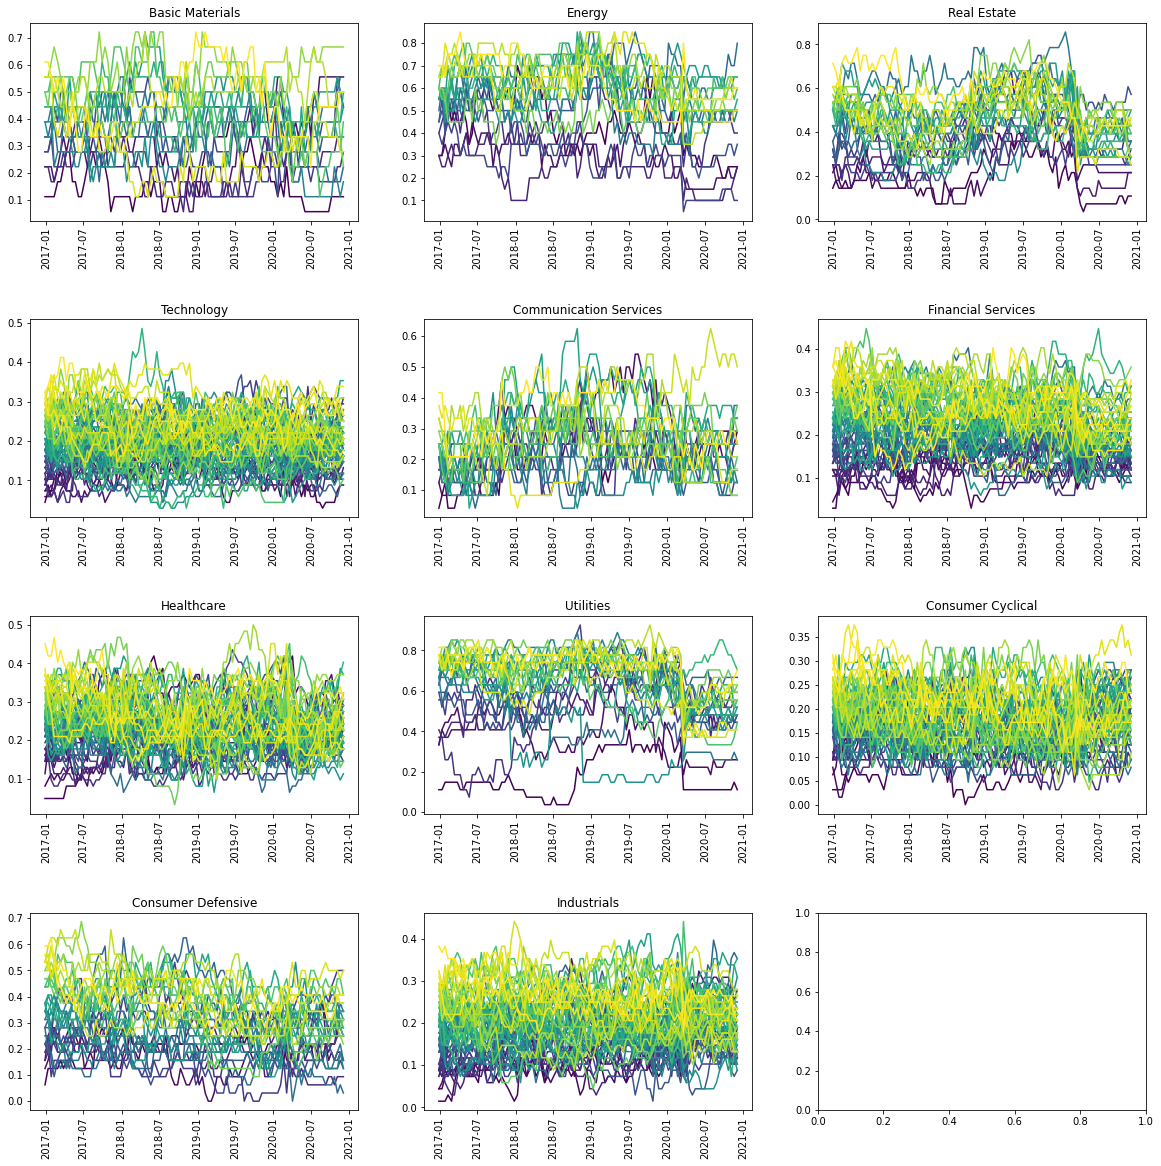

In [51]:
plot_graph_stat(degree, x = dates)

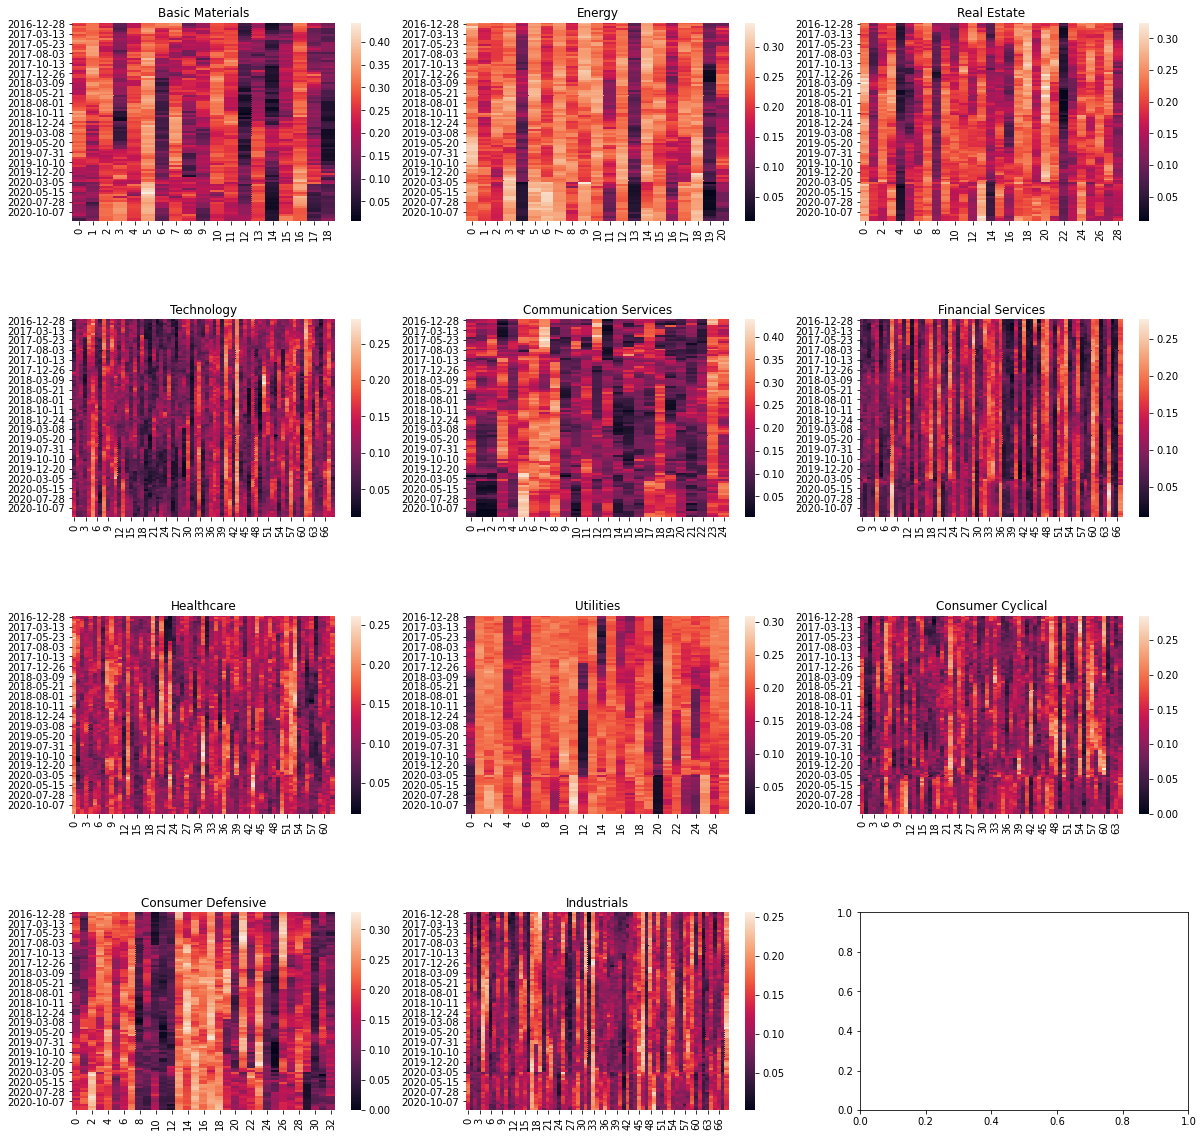

In [52]:
plot_graph_stat(eigcentrality, x = dates, heat=True)

# Graph sample hypothesis covid

In [66]:
unweighted_undirected_network_sector_list.keys()

dict_keys(['Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities'])

In [14]:
P_val_df = pd.DataFrame(columns= ['MMD_b', 'MMD_u', 'MONK_EST', 'B', 'sector'])

for sector in unweighted_undirected_network_sector_list.keys():
  print(sector)
  change_point = np.sum(np.array(dates[sector]) < datetime.date(2020, 3, 12))

  m = len(unweighted_undirected_network_sector_list[sector][change_point:])


  G1 = unweighted_undirected_network_sector_list[sector][(change_point-m):change_point]
  G2 = unweighted_undirected_network_sector_list[sector][change_point:]
  n = len(G1)
  assert n == m
  Gs = G1 + G2
  rw_kernel = rw.RandomWalk(Gs, normalize= 0, c = 0.001)
  K = rw_kernel.fit_ARKU_plus(r = 10)

  MMD_functions = [mg.MMD_b, mg.MMD_u]

  # initialize bootstrap class, we only want this to be initalized once so that numba njit
  # only gets compiled once (at first call)
  kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
  function_arguments=[dict(n = n, m = m), dict(n = n, m = m )]
  kernel_hypothesis.Bootstrap(K, function_arguments, B = 3000)

  # Permutation
  MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MONK_EST]
  kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
  function_arguments = [dict(n = n, m = m  ), 
                        dict(n = n, m =m ), 
                      dict(Q = 11, y1 = Gs[:n], y2 = Gs[n:] )]

  kernel_hypothesis.Bootstrap(K, function_arguments, B = 3000)
  print(f'p_value {kernel_hypothesis.p_values}')
  print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

  tmp_df_1 = pd.DataFrame(kernel_hypothesis.p_values, index = [0])
  tmp_df_1['B'] = 1
  tmp_df_1['sector'] = sector
  P_val_df = P_val_df.append(tmp_df_1)

  MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MONK_EST]
  kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
  function_arguments = [dict(n = n, m = m  ), 
                        dict(n = n, m = m ), 
                      dict(Q = 15, y1 = Gs[:n], y2 = Gs[n:] )]

  kernel_hypothesis.Bootstrap(K, function_arguments, B = 3000, method = 'NBB', boot_arg = {'l':5 ,'n':n, 'm':m})
  print(f'p_value {kernel_hypothesis.p_values}')
  print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

  tmp_df_2 = pd.DataFrame(kernel_hypothesis.p_values, index = [0])
  tmp_df_2['B'] = 5
  tmp_df_2['sector'] = sector
  P_val_df = P_val_df.append(tmp_df_2)



  0%|          | 8/13530.0 [00:00<02:53, 77.88it/s]

Basic Materials


100%|██████████| 13530/13530.0 [00:25<00:00, 540.26it/s]


p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0003333333333333333}
MMD_u 0.02983027224649959


  0%|          | 27/13530.0 [00:00<00:51, 263.98it/s]

p_value {'MMD_b': 0.084, 'MMD_u': 0.084, 'MONK_EST': 0.11966666666666667}
MMD_u 0.02983027224649959
Communication Services


100%|██████████| 13530/13530.0 [00:17<00:00, 794.68it/s]


p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 0.8633851658062213


  0%|          | 26/13530.0 [00:00<00:53, 252.50it/s]

p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 0.8633851658062213
Consumer Cyclical


100%|██████████| 13530/13530.0 [00:16<00:00, 797.94it/s]


p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 1.0540589373922558


  0%|          | 30/13530.0 [00:00<00:45, 294.90it/s]

p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0006666666666666666}
MMD_u 1.0540589373922558
Consumer Defensive


100%|██████████| 13530/13530.0 [00:16<00:00, 813.57it/s]


p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 0.3697167457971773


  0%|          | 48/13530.0 [00:00<00:28, 471.85it/s]

p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 0.3697167457971773
Energy


100%|██████████| 13530/13530.0 [00:16<00:00, 809.18it/s]


p_value {'MMD_b': 0.7883333333333333, 'MMD_u': 0.7883333333333333, 'MONK_EST': 0.483}
MMD_u -0.009766680768052538


  0%|          | 26/13530.0 [00:00<00:53, 253.10it/s]

p_value {'MMD_b': 0.903, 'MMD_u': 0.903, 'MONK_EST': 0.999}
MMD_u -0.009766680768052538
Financial Services


100%|██████████| 13530/13530.0 [00:17<00:00, 769.96it/s]


p_value {'MMD_b': 0.5066666666666667, 'MMD_u': 0.5066666666666667, 'MONK_EST': 0.5656666666666667}
MMD_u -0.02156881733026239


  0%|          | 25/13530.0 [00:00<00:55, 245.23it/s]

p_value {'MMD_b': 0.7596666666666667, 'MMD_u': 0.7596666666666667, 'MONK_EST': 0.666}
MMD_u -0.02156881733026239
Healthcare


100%|██████████| 13530/13530.0 [00:16<00:00, 803.13it/s]


p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 0.2823239602303147


  0%|          | 24/13530.0 [00:00<00:57, 233.63it/s]

p_value {'MMD_b': 0.027333333333333334, 'MMD_u': 0.027333333333333334, 'MONK_EST': 0.04633333333333333}
MMD_u 0.2823239602303147
Industrials


100%|██████████| 13530/13530.0 [00:16<00:00, 801.11it/s]


p_value {'MMD_b': 0.16366666666666665, 'MMD_u': 0.16366666666666665, 'MONK_EST': 0.436}
MMD_u 0.007312148420169251


  0%|          | 36/13530.0 [00:00<00:37, 357.39it/s]

p_value {'MMD_b': 0.45766666666666667, 'MMD_u': 0.45766666666666667, 'MONK_EST': 0.36633333333333334}
MMD_u 0.007312148420169251
Real Estate


100%|██████████| 13530/13530.0 [00:16<00:00, 810.78it/s]


p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 1.6942901079905823


  0%|          | 25/13530.0 [00:00<00:55, 243.37it/s]

p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 1.6942901079905823
Technology


100%|██████████| 13530/13530.0 [00:17<00:00, 779.32it/s]


p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 0.6172440522623219


  0%|          | 36/13530.0 [00:00<00:38, 350.45it/s]

p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 0.6172440522623219
Utilities


100%|██████████| 13530/13530.0 [00:16<00:00, 813.16it/s]


p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 3.4040153782063953
p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.0}
MMD_u 3.4040153782063953


In [23]:
P_val_df['B'].loc[P_val_df['B'] == 1] = "Permutation"
P_val_df['B'].loc[P_val_df['B'] == 5] = "Block Bootstrap"

P_val_df.loc[P_val_df['sector'].isin(["Basic Materials", "Energy", "Real Estate", "Communication Services", "Technology", "Financial Services"])]

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,MMD_b,MMD_u,MONK_EST,B,sector
0,0.000000,0.000000,0.000333,Permutation,Basic Materials
0,0.084000,0.084000,0.119667,Block Bootstrap,Basic Materials
0,0.000000,0.000000,0.000000,Permutation,Communication Services
0,0.000000,0.000000,0.000000,Block Bootstrap,Communication Services
0,0.788333,0.788333,0.483000,Permutation,Energy
0,0.903000,0.903000,0.999000,Block Bootstrap,Energy
0,0.506667,0.506667,0.565667,Permutation,Financial Services
0,0.759667,0.759667,0.666000,Block Bootstrap,Financial Services
0,0.000000,0.000000,0.000000,Permutation,Real Estate
0,0.000000,0.000000,0.000000,Block Bootstrap,Real Estate


In [64]:
tmp_df_1 = pd.DataFrame(kernel_hypothesis.p_values, index = [0])
tmp_df_1['B'] = 1

In [54]:
MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MONK_EST]
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments = [dict(n = n, m = m  ), 
                      dict(n = n, m =m ), 
                    dict(Q = 11, y1 = Gs[:n], y2 = Gs[n:] )]

kernel_hypothesis.Bootstrap(K, function_arguments, B = 3000)
print(f'p_value {kernel_hypothesis.p_values}')
print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MONK_EST': 0.015333333333333332}
MMD_u 0.02983027224649959


In [58]:
MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MONK_EST]
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments = [dict(n = n, m = m  ), 
                      dict(n = n, m = m ), 
                    dict(Q = 15, y1 = Gs[:n], y2 = Gs[n:] )]

kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000, method = 'NBB', boot_arg = {'l':5 ,'n':n, 'm':m})
print(f'p_value {kernel_hypothesis.p_values}')
print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

p_value {'MMD_b': 0.095, 'MMD_u': 0.095, 'MONK_EST': 0.143}
MMD_u 0.02983027224649959


<AxesSubplot:>

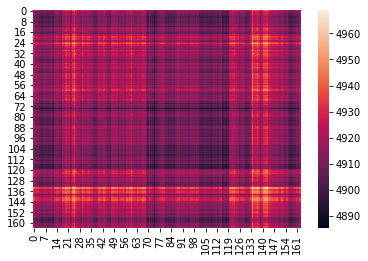

In [47]:
sns.heatmap(K)

In [34]:
np.array(dates['Industrials'])

array([datetime.date(2016, 12, 28), datetime.date(2017, 1, 5),
       datetime.date(2017, 1, 12), datetime.date(2017, 1, 20),
       datetime.date(2017, 1, 27), datetime.date(2017, 2, 3),
       datetime.date(2017, 2, 10), datetime.date(2017, 2, 17),
       datetime.date(2017, 2, 27), datetime.date(2017, 3, 6),
       datetime.date(2017, 3, 13), datetime.date(2017, 3, 20),
       datetime.date(2017, 3, 27), datetime.date(2017, 4, 3),
       datetime.date(2017, 4, 10), datetime.date(2017, 4, 18),
       datetime.date(2017, 4, 25), datetime.date(2017, 5, 2),
       datetime.date(2017, 5, 9), datetime.date(2017, 5, 16),
       datetime.date(2017, 5, 23), datetime.date(2017, 5, 31),
       datetime.date(2017, 6, 7), datetime.date(2017, 6, 14),
       datetime.date(2017, 6, 21), datetime.date(2017, 6, 28),
       datetime.date(2017, 7, 6), datetime.date(2017, 7, 13),
       datetime.date(2017, 7, 20), datetime.date(2017, 7, 27),
       datetime.date(2017, 8, 3), datetime.date(2017, 8, 10),


In [90]:
len(Gsample2)

100

In [115]:
sectors[7]

'Industrials'

In [108]:
p_vals = np.ones((len(unweighted_undirected_network_sector_list), len(unweighted_undirected_network_sector_list)))
sectors = list(unweighted_undirected_network_sector_list.keys())
for i in range(len(unweighted_undirected_network_sector_list)):
    for j in range(i, len(unweighted_undirected_network_sector_list)):


        Gsample1 = unweighted_undirected_network_sector_list[sectors[i]]
        Gsample2 = unweighted_undirected_network_sector_list[sectors[j]]


        assert len(Gsample1) == len(Gsample2)
        nr_samples = len(Gsample1)
        print(nr_samples)

        Gs = Gsample1 + Gsample2



        graph_list = gk.graph_from_networkx(Gs, node_labels_tag='label')  # Convert to graphs to Grakel format
        # kernel = [{"name": "multiscale_laplacian"}]
        # K = mg.KernelMatrix(graph_list, kernel, False)   
        # kernel = [{"name": "weisfeiler_lehman", "n_iter": 4}, {"name": "vertex_histogram"}]
        kernel = [{"name": "SP", "with_labels": False}]
        #kernel = [{"name": "WL-OA", "n_iter": 4}]
        # kernel = [{"name": "lovasz_theta", "n_samples":20}]
        #kernel = [{"name": "core_framework", "min_core": 1}, {"name":"propagation", 't_max':5, 'w':0.1, 'M':"H"}]
        # kernel = [{"name": "pyramid_match", "with_labels":True, "d":1, "L":2}] 
        #kernel = [{"name":'RW', 'kernel_type':'geometric', 'lamda':0.1, 'with_labels':False, 'p':3}]
        #kernel = [{"name":'odd_sth', 'h':3}]
        # kernel = [{"name": "propagation", "t_max": 4, "w":1, "M":'TV'}]
        init_kernel = gk.GraphKernel(kernel= kernel, normalize=1, n_jobs= 4)
        K = init_kernel.fit_transform(graph_list)

        # My kernels
        # RW kernel
        # label list for rw
        # label_list = []
        # for G in Gs:
        #     label_list.append(np.unique(list(nx.get_node_attributes(G, 'label').values())))

        # label_list = np.unique(np.concatenate(label_list))
        #rw_kernel = rw.RandomWalk(Gs, normalize= True, c = 0.001)
        # K = rw_kernel.fit_ARKL(r = 2, label_list = label_list, normalize_adj=True)
        # K = rw_kernel.fit_ARKU_plus(r = 10)

        #print(np.all(K == 0)) 
        #print(K)


        MMD_functions = [mg.MMD_b, mg.MMD_u]

        # initialize bootstrap class, we only want this to be initalized once so that numba njit
        # only gets compiled once (at first call)
        kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
        function_arguments=[dict(n = nr_samples, m = nr_samples), dict(n = nr_samples, m = nr_samples )]
        kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000)


        # Run power
        threshold = np.quantile(kernel_hypothesis.boot_test_statistic['MMD_u'], 1-0.5)
        print(f'threshold {threshold}')
        ratio, power, V = mg.power_ratio(K, kernel_hypothesis.sample_test_statistic['MMD_u'], nr_samples*threshold, nr_samples)
        print(f'V {V}')
        print(f'ratio {ratio}')
        print(f'power {power}')
        print(f'p_value {kernel_hypothesis.p_values}')
        print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

        p_vals[i,j] = kernel_hypothesis.p_values['MMD_u']

100
threshold -4.0564500683792915e-05
V 7.909134954032322
ratio -2.6170863962730363e-05
power 0.4999895593358518
p_value {'MMD_b': 1.0, 'MMD_u': 1.0}
MMD_u -0.00011416530374597222
100


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\grakel\kernels\shortest_path.py:241: UserWarning: no implemented parallelization for ShortestPath
  warnings.warn('no implemented parallelization for ShortestPath')


threshold -0.00026370062237013325
V 7.261504695523102
ratio 0.02496493687363783
power 0.5099585343961412
p_value {'MMD_b': 0.0, 'MMD_u': 0.0}
MMD_u 0.0670097622684731
100
threshold -0.0003747543273334708
V 6.952663000627371
ratio 0.048594596978563366
power 0.5193788120667804
p_value {'MMD_b': 0.0, 'MMD_u': 0.0}
MMD_u 0.1277590068298622
100
threshold -6.823879893835816e-05
V 7.782421153805305
ratio 0.006374125406920729
power 0.502542890906003
p_value {'MMD_b': 0.0, 'MMD_u': 0.0}
MMD_u 0.01771365320944507
100
threshold -0.00027177768583974693
V 7.260824134745511
ratio 0.029843978999222455
power 0.5119042578981375
p_value {'MMD_b': 0.0, 'MMD_u': 0.0}
MMD_u 0.08014555878700436
100
threshold -0.00022532387660911812
V 7.276169626255833
ratio 0.03181056784189135
power 0.5126884405082803
p_value {'MMD_b': 0.0, 'MMD_u': 0.0}
MMD_u 0.08558169801752324
100
threshold -0.00023058677131893024
V 7.254210895205514
ratio 0.0331321231711737
power 0.5132153868904092
p_value {'MMD_b': 0.0, 'MMD_u': 0.0}
M

<AxesSubplot:>

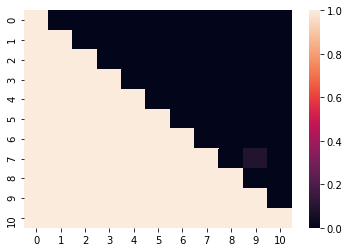

In [109]:
sns.heatmap(p_vals)